In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

In [6]:
from recsys_training.data import Dataset
from recsys_training.evaluation import retrieval_score
from recsys_training.model import BPRRecommender
from recsys_training.utils import sigmoid, df_to_coo, coo_to_df

In [7]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

/anaconda3/envs/recsys_training/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [8]:
k = 16
N = 10
seed = 42
learning_rate = 0.05

## Data

* LightFM MovieLens Default train-test-split
* Own BPR Model Implementation

In [9]:
ml100k_filepath = '../data/raw/ml-100k/u.data'

data_df = {}
data_coo = {}

data_coo['lightfm'] = fetch_movielens(min_rating=4.0)
data_df['own'] = Dataset(ml100k_filepath)
data_df['own'].binarize(min_rating=4.0)
data_df['own'].rating_split(seed=42)

# Create sparse matrices in COO format from own data split
data_coo['own'] = dict.fromkeys(['train', 'test'])
data_coo['own']['train'] = df_to_coo(data_df['own'].train_ratings,
                                     data_df['own'].n_users,
                                     data_df['own'].n_items)
data_coo['own']['test'] = df_to_coo(data_df['own'].test_ratings,
                                    data_df['own'].n_users,
                                    data_df['own'].n_items)

# Create pandas dataframes from LightFM data in COO format
data_df['lightfm'] = dict.fromkeys(['train', 'test'])
data_df['lightfm']['train'] = coo_to_df(data_coo['lightfm']['train'])
data_df['lightfm']['test'] = coo_to_df(data_coo['lightfm']['test'])

In [10]:
data_coo['lightfm']

{'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 49906 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 5469 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [11]:
data_coo['own']

{'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 44300 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 11075 stored elements in COOrdinate format>}

## Training and Evaluation

### LightFM Datasplits

In [121]:
own_model = BPRRecommender(data_df['lightfm']['train'],
                           data_df['own'].users,
                           data_df['own'].items,
                           k=k, N=N, seed=seed)
lfm_model = LightFM(loss='bpr', learning_rate=learning_rate, no_components=k, random_state=seed)

own_map_train_trace = []
own_map_test_trace = []
lightfm_map_train_trace = []
lightfm_map_test_trace = []
epochs = 30

for epoch in range(epochs):
    print(f"Training and Evaluation Epoch {epoch+1:02d}")
    own_model.train(epochs=1, learning_rate=learning_rate, verbose=False)
    train_map_at_k = retrieval_score(data_df['lightfm']['train'],
                                     recommender=own_model,
                                     metric='map')
    test_map_at_k = retrieval_score(data_df['lightfm']['test'],
                                    recommender=own_model,
                                    remove_known_pos=True,
                                    metric='map')
    own_map_train_trace.append(train_map_at_k)
    own_map_test_trace.append(test_map_at_k)
    
    lfm_model.fit_partial(data_coo['lightfm']['train'])
    train_map_at_k = precision_at_k(lfm_model, data_coo['lightfm']['train'], k=N)
    test_map_at_k = precision_at_k(lfm_model,
                                   data_coo['lightfm']['test'],
                                   data_coo['lightfm']['train'],
                                   k=N)
    
    lightfm_map_train_trace.append(train_map_at_k.mean())
    lightfm_map_test_trace.append(test_map_at_k.mean())

Training and Evaluation Epoch 01
Training and Evaluation Epoch 02
Training and Evaluation Epoch 03
Training and Evaluation Epoch 04
Training and Evaluation Epoch 05
Training and Evaluation Epoch 06
Training and Evaluation Epoch 07
Training and Evaluation Epoch 08
Training and Evaluation Epoch 09
Training and Evaluation Epoch 10
Training and Evaluation Epoch 11
Training and Evaluation Epoch 12
Training and Evaluation Epoch 13
Training and Evaluation Epoch 14
Training and Evaluation Epoch 15
Training and Evaluation Epoch 16
Training and Evaluation Epoch 17
Training and Evaluation Epoch 18
Training and Evaluation Epoch 19
Training and Evaluation Epoch 20
Training and Evaluation Epoch 21
Training and Evaluation Epoch 22
Training and Evaluation Epoch 23
Training and Evaluation Epoch 24
Training and Evaluation Epoch 25
Training and Evaluation Epoch 26
Training and Evaluation Epoch 27
Training and Evaluation Epoch 28
Training and Evaluation Epoch 29
Training and Evaluation Epoch 30


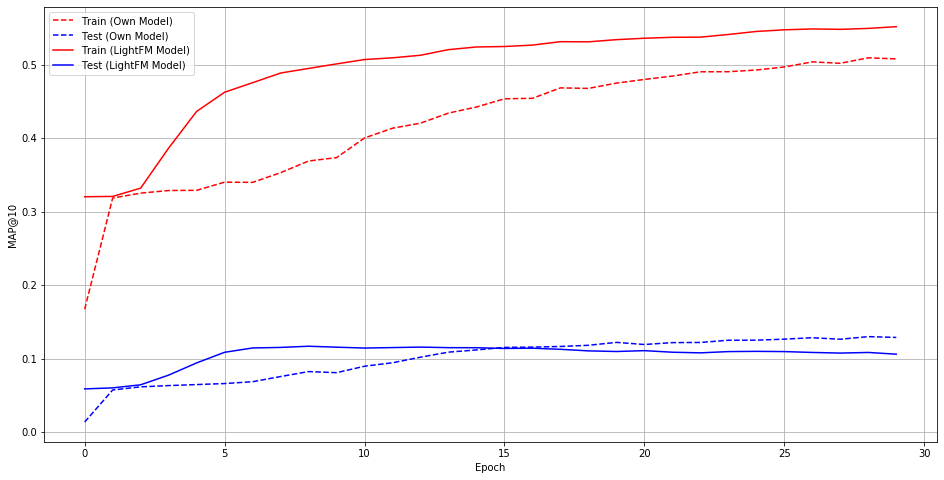

In [123]:
plt.figure(figsize=(16, 8))
plt.plot(range(epochs), own_map_train_trace, 'r--', label='Train (Own Model)')
plt.plot(range(epochs), own_map_test_trace, 'b--', label='Test (Own Model)')
plt.plot(range(epochs), lightfm_map_train_trace, 'r-', label='Train (LightFM Model)')
plt.plot(range(epochs), lightfm_map_test_trace, 'b-', label='Test (LightFM Model)')
plt.xlabel('Epoch')
plt.ylabel('MAP@10')
plt.legend()
plt.grid(True)
plt.show()

### Own Datasplits

In [128]:
own_model = BPRRecommender(data_df['own'].train_ratings,
                           data_df['own'].users,
                           data_df['own'].items,
                           k=k, N=N, seed=seed)
lfm_model = LightFM(loss='bpr', learning_rate=learning_rate, no_components=k, random_state=seed)

own_map_train_trace = []
own_map_test_trace = []
lightfm_map_train_trace = []
lightfm_map_test_trace = []
epochs = 30

for epoch in range(epochs):
    print(f"Training and Evaluation Epoch {epoch+1:02d}")
    own_model.train(epochs=1, learning_rate=learning_rate, verbose=False)
    train_map_at_k = retrieval_score(data_df['own'].train_ratings,
                                     recommender=own_model,
                                     metric='map')
    test_map_at_k = retrieval_score(data_df['own'].test_ratings,
                                    recommender=own_model,
                                    remove_known_pos=True,
                                    metric='map')
    own_map_train_trace.append(train_map_at_k)
    own_map_test_trace.append(test_map_at_k)
    
    lfm_model.fit_partial(data_coo['own']['train'])
    train_map_at_k = precision_at_k(lfm_model, data_coo['own']['train'], k=N)
    test_map_at_k = precision_at_k(lfm_model,
                                   data_coo['own']['test'],
                                   data_coo['own']['train'],
                                   k=N)
    
    lightfm_map_train_trace.append(train_map_at_k.mean())
    lightfm_map_test_trace.append(test_map_at_k.mean())

Training and Evaluation Epoch 01
Training and Evaluation Epoch 02
Training and Evaluation Epoch 03
Training and Evaluation Epoch 04
Training and Evaluation Epoch 05
Training and Evaluation Epoch 06
Training and Evaluation Epoch 07
Training and Evaluation Epoch 08
Training and Evaluation Epoch 09
Training and Evaluation Epoch 10
Training and Evaluation Epoch 11
Training and Evaluation Epoch 12
Training and Evaluation Epoch 13
Training and Evaluation Epoch 14
Training and Evaluation Epoch 15
Training and Evaluation Epoch 16
Training and Evaluation Epoch 17
Training and Evaluation Epoch 18
Training and Evaluation Epoch 19
Training and Evaluation Epoch 20
Training and Evaluation Epoch 21
Training and Evaluation Epoch 22
Training and Evaluation Epoch 23
Training and Evaluation Epoch 24
Training and Evaluation Epoch 25
Training and Evaluation Epoch 26
Training and Evaluation Epoch 27
Training and Evaluation Epoch 28
Training and Evaluation Epoch 29
Training and Evaluation Epoch 30


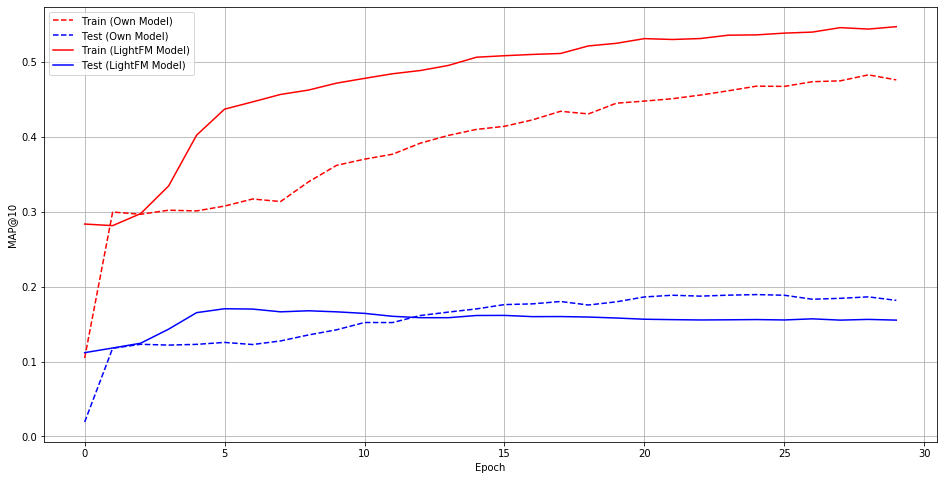

In [129]:
plt.figure(figsize=(16, 8))
plt.plot(range(epochs), own_map_train_trace, 'r--', label='Train (Own Model)')
plt.plot(range(epochs), own_map_test_trace, 'b--', label='Test (Own Model)')
plt.plot(range(epochs), lightfm_map_train_trace, 'r-', label='Train (LightFM Model)')
plt.plot(range(epochs), lightfm_map_test_trace, 'b-', label='Test (LightFM Model)')
plt.xlabel('Epoch')
plt.ylabel('MAP@10')
plt.legend()
plt.grid(True)
plt.show()

## Regularized Tests

In [29]:
l2_decay = {'user': 0.01, 'pos': 0.005, 'neg': 0.005}
epochs = 30

In [30]:
recommender = BPRRecommender(data_df['own'].train_ratings,
                             data_df['own'].users,
                             data_df['own'].items,
                             k=k, N=N, seed=seed)

map_train_trace = []
map_test_trace = []


for epoch in range(epochs):
    print(f"Training and Evaluation Epoch {epoch+1:02d}")
    recommender.train(epochs=1,
                      learning_rate=learning_rate,
                      l2_decay=l2_decay,
                      verbose=False)
    train_map_at_k = retrieval_score(data_df['own'].train_ratings,
                                      recommender=recommender,
                                      metric='map')
    test_map_at_k = retrieval_score(data_df['own'].test_ratings,
                                     recommender=recommender,
                                     remove_known_pos=True,
                                     metric='map')
    map_train_trace.append(train_map_at_k)
    map_test_trace.append(test_map_at_k)

Training and Evaluation Epoch 01
[2019-12-19 13:52:48] INFO:recsys_training.model:L2 Decay regularization (user, pos, neg): {'user': 0.01, 'pos': 0.005, 'neg': 0.005}
Training and Evaluation Epoch 02
[2019-12-19 13:52:53] INFO:recsys_training.model:L2 Decay regularization (user, pos, neg): {'user': 0.01, 'pos': 0.005, 'neg': 0.005}
Training and Evaluation Epoch 03
[2019-12-19 13:52:58] INFO:recsys_training.model:L2 Decay regularization (user, pos, neg): {'user': 0.01, 'pos': 0.005, 'neg': 0.005}
Training and Evaluation Epoch 04
[2019-12-19 13:53:03] INFO:recsys_training.model:L2 Decay regularization (user, pos, neg): {'user': 0.01, 'pos': 0.005, 'neg': 0.005}
Training and Evaluation Epoch 05
[2019-12-19 13:53:07] INFO:recsys_training.model:L2 Decay regularization (user, pos, neg): {'user': 0.01, 'pos': 0.005, 'neg': 0.005}
Training and Evaluation Epoch 06
[2019-12-19 13:53:12] INFO:recsys_training.model:L2 Decay regularization (user, pos, neg): {'user': 0.01, 'pos': 0.005, 'neg': 0.005

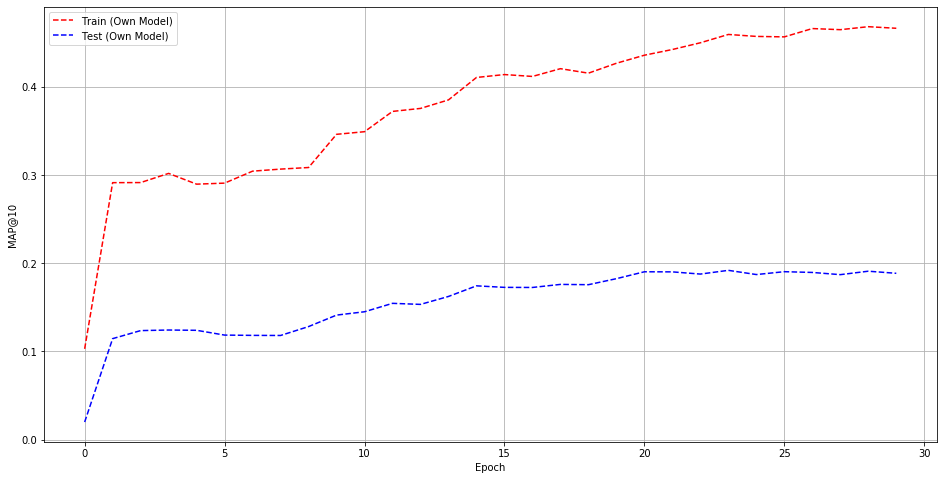

In [31]:
plt.figure(figsize=(16, 8))
plt.plot(range(epochs), map_train_trace, 'r--', label='Train (Own Model)')
plt.plot(range(epochs), map_test_trace, 'b--', label='Test (Own Model)')
plt.xlabel('Epoch')
plt.ylabel('MAP@10')
plt.legend()
plt.grid(True)
plt.show()